In [11]:
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from algorithms.bisection import BisectionLearner
from algorithms.exp_weights import ExpWeights
from algorithms.exp_fast import ExpWeightsFast
from algorithms.ons import ONS
from algorithms.thompson_sampling import ThompsonSamplingLearner
from bandit import BanditProblem
from runner import Runner

np.random.seed(42)

n = 100  # number of basis functions
B = 5.0  # budget on sum of weights
sigma = 1  # noise standard deviation
horizon = 100  # number of time steps per trial
num_trials = 3  # number of independent trials

prior_mu = np.random.uniform(0, 1, n)
B_mu = np.random.uniform(0, 1) * B
prior_mu = prior_mu / np.sum(prior_mu) * B_mu
prior_Sigma = np.eye(n) * 1.0

learner_configs = [
    (
        "ThompsonSampling",
        ThompsonSamplingLearner,
        {
            "prior_mu": prior_mu,
            "prior_Sigma": prior_Sigma,
            "B": B,
            "n": n,
            "noise_sigma": sigma,
            "burn_in": 500,
        },
    ),
    (
        "BisectionLearner",
        BisectionLearner,
        {
            "initial_interval": [0, 1],
            "horizon": horizon,
            "delta": 1 / np.sqrt(horizon),
            "sigma": sigma,
            "confidence_const": 24,
        },
    ),
    (
        "ExpWeights",
        ExpWeights,
        {"horizon": horizon},
    ),
    # (
    #     "ExpWeightsFast",
    #     ExpWeightsFast,
    #     {"horizon": horizon},
    # ),
    # (
    #     "ONS",
    #     ONS,
    #     {
    #         "horizon": horizon,
    #         "interval": [-1, 1],
    #         "delta": 1 / np.sqrt(horizon),
    #         "M": 1,
    #         "C": 1,
    #     },
    # ),
]

In [12]:
# Plotting tools
# Plot the true function
x = np.linspace(0, 1, 500)


def phi(x, t):
    """Basis function: |x - t|."""
    return np.abs(x - t)


def f(x, w, n):
    ts = np.linspace(1 / n, 1, n)
    x = np.atleast_1d(x)
    return np.sum(np.array([phi(x, t) for t in ts]).T * w, axis=1)


def plot(f_star, runner):
    sns.set_theme(style="ticks", context="paper", font_scale=1)
    n_learners = len(runner.learners)
    fig, axs = plt.subplots(1, n_learners, figsize=(5 * n_learners, 5), squeeze=False)
    axs = axs[0]  # get the row of axes

    algo_names = list(runner.learners[0].keys())

    colors = [
        "blue",
        "green",
        "red",
        "purple",
        "orange",
        "brown",
        "pink",
        "gray",
        "olive",
        "cyan",
    ]

    for j in range(n_learners):
        ax = axs[j]
        y_true = [f_star(x_i) for x_i in x]
        ax.plot(x, y_true, label="True function", color="black", linewidth=2)

        ts = runner.learners[j]["ThompsonSampling"]
        for i in range(horizon):
            if i % 3 != 0:
                continue
            # plot Thompson Sampling's function estimates
            ws = ts.ws[i]
            xs = np.linspace(0, 1, 500)
            ys = f(xs, ws, n)
            if i == 0:
                ax.plot(
                    xs,
                    ys,
                    alpha=np.exp(0.01 * (i - horizon)),
                    linestyle=":",
                    color="black",
                    label="TS-Sampled Functions",
                )
            else:
                ax.plot(
                    xs,
                    ys,
                    alpha=np.exp(0.01 * (i - horizon)),
                    linestyle=":",
                    color="black",
                )

            for k, alg_name in enumerate(algo_names):
                learner = runner.learners[j][alg_name]
                action = learner.history_x[i]
                if i == 0:
                    ax.scatter(
                        action,
                        f_star(action),
                        color=colors[k],
                        label=alg_name,
                        edgecolor="k",
                        # alpha=(1 / horizon) * i,
                        zorder=3,
                    )
                else:
                    ax.scatter(
                        action,
                        f_star(action),
                        color=colors[k],
                        edgecolor="k",
                        alpha=np.exp(0.01 * (i - horizon)),
                        zorder=3,
                        s=100 * np.exp(0.01 * (i - horizon)),
                    )
        ax.legend()

    plt.tight_layout()
    plt.show()

## Quadratic

In [ ]:
from utils import quadratic

m = 0.2
a = 4
quadratic = partial(quadratic, m=m, a=a)

bandit = BanditProblem(w_true=None, ts=None, sigma=sigma, f_star=quadratic)

quadratic_runner = Runner(None, learner_configs, horizon, num_trials, problem=bandit)
quadratic_runner.run()

Optimal action and value:  Optimal action and value: (np.float64(0.20020020020020018), np.float64(1.6032048064075818e-07))
 Optimal action and value:  (np.float64(0.20020020020020018), np.float64(1.6032048064075818e-07))
(np.float64(0.20020020020020018), np.float64(1.6032048064075818e-07))
Trial 2/3, Time step 0/100, Learner ThompsonSampling, Regret: 0.31359983967951943
Trial 2/3, Time step 0/100, Learner BisectionLearner, Regret: 0.009999839679519354
Trial 2/3, Time step 0/100, Learner ExpWeights, Regret: 0.3599998396795194
Trial 1/3, Time step 0/100, Learner ThompsonSampling, Regret: 0.4899998396795195
Trial 1/3, Time step 0/100, Learner BisectionLearner, Regret: 0.009999839679519354
Trial 3/3, Time step 0/100, Learner ThompsonSampling, Regret: 0.1935998396795194
Trial 3/3, Time step 0/100, Learner BisectionLearner, Regret: 0.009999839679519354
Trial 1/3, Time step 0/100, Learner ExpWeights, Regret: 0.9999998396795193
Trial 3/3, Time step 0/100, Learner ExpWeights, Regret: 0.15999983

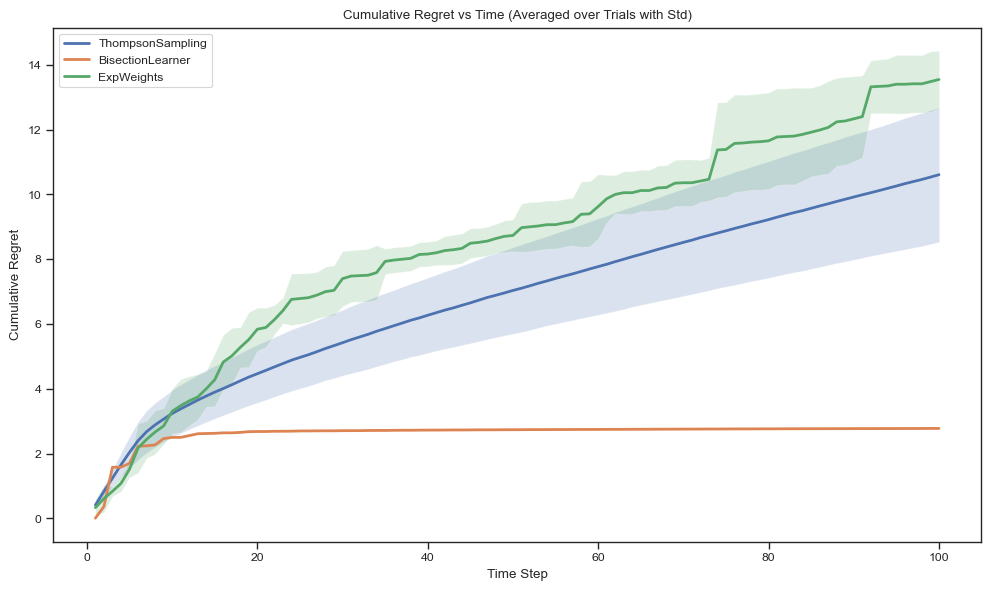

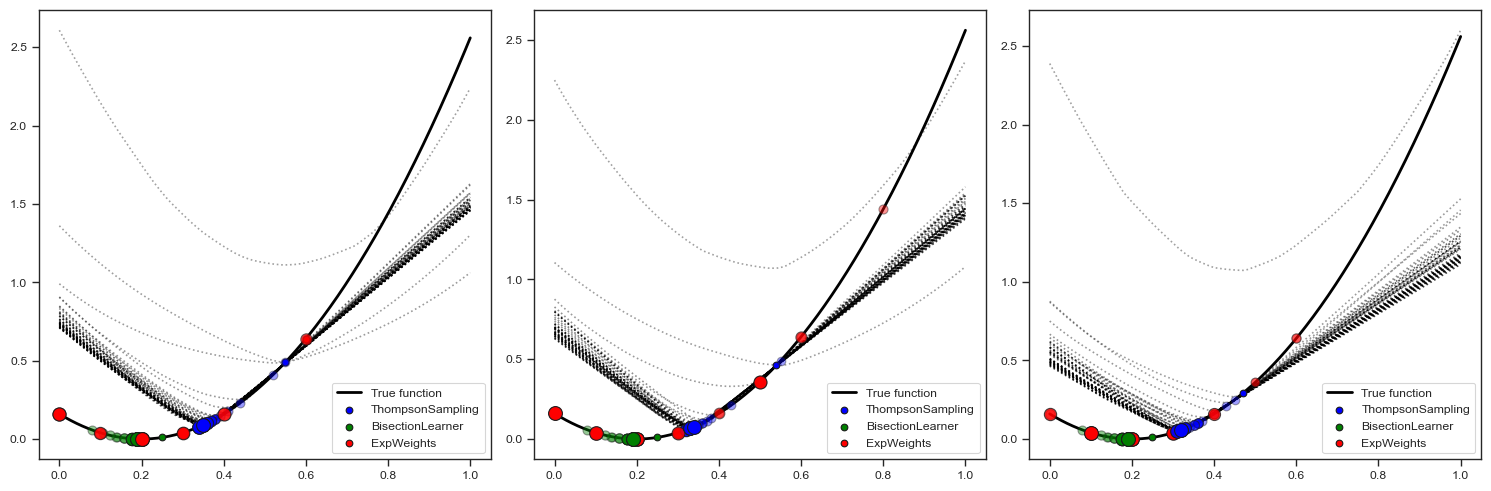

In [4]:
quadratic_runner.plot_regret()
plot(quadratic, quadratic_runner)

## Absolute Value

In [5]:
from utils import absolute_value

m = 0.2
a = 4
absolute_value = partial(absolute_value, m=m, a=a)

bandit = BanditProblem(w_true=None, ts=None, sigma=sigma, f_star=absolute_value)

absolute_runner = Runner(None, learner_configs, horizon, num_trials, problem=bandit)
absolute_runner.run()

Optimal action and value:  Optimal action and value: (np.float64(0.20020020020020018), np.float64(0.0008008008008006939))
 (np.float64(0.20020020020020018), np.float64(0.0008008008008006939))
Optimal action and value:  (np.float64(0.20020020020020018), np.float64(0.0008008008008006939))
Trial 3/3, Time step 0/100, Learner ThompsonSampling, Regret: 1.2391991991991993
Trial 3/3, Time step 0/100, Learner BisectionLearner, Regret: 0.19919919919919926
Trial 3/3, Time step 0/100, Learner ExpWeights, Regret: 1.1991991991991993
Trial 1/3, Time step 0/100, Learner ThompsonSampling, Regret: 1.4391991991991995
Trial 1/3, Time step 0/100, Learner BisectionLearner, Regret: 0.19919919919919926
Trial 1/3, Time step 0/100, Learner ExpWeights, Regret: 1.1991991991991993
Trial 2/3, Time step 0/100, Learner ThompsonSampling, Regret: 0.9991991991991993
Trial 2/3, Time step 0/100, Learner BisectionLearner, Regret: 0.19919919919919926
Trial 2/3, Time step 0/100, Learner ExpWeights, Regret: 1.199199199199199

{'ThompsonSampling': [array([ 1.2391992 ,  2.4783984 ,  3.7175976 ,  4.9567968 ,  6.195996  ,
          7.4351952 ,  8.67439439,  9.91359359, 11.15279279, 12.39199199,
         13.63119119, 14.87039039, 16.10958959, 17.34878879, 18.58798799,
         19.82718719, 21.06638639, 22.30558559, 23.50478478, 23.62398398,
         23.74318318, 23.78238238, 23.78158158, 23.78078078, 23.77997998,
         23.77917918, 23.77837838, 23.77757758, 23.77677678, 23.77597598,
         23.81517518, 23.81437437, 23.81357357, 23.81277277, 23.81197197,
         23.81117117, 23.81037037, 23.80956957, 23.80876877, 23.80796797,
         23.80716717, 23.80636637, 23.80556557, 23.80476476, 23.80396396,
         23.80316316, 23.80236236, 23.80156156, 23.80076076, 23.79995996,
         23.79915916, 23.79835836, 23.79755756, 23.79675676, 23.79595596,
         23.79515516, 23.79435435, 23.79355355, 23.79275275, 23.79195195,
         23.79115115, 23.79035035, 23.78954955, 23.78874875, 23.78794795,
         23.787147

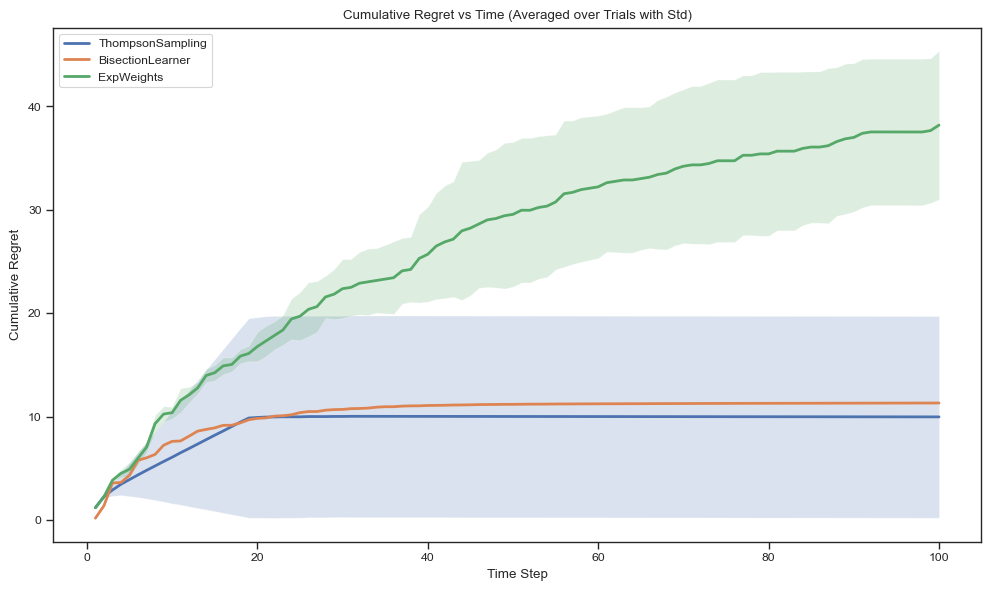

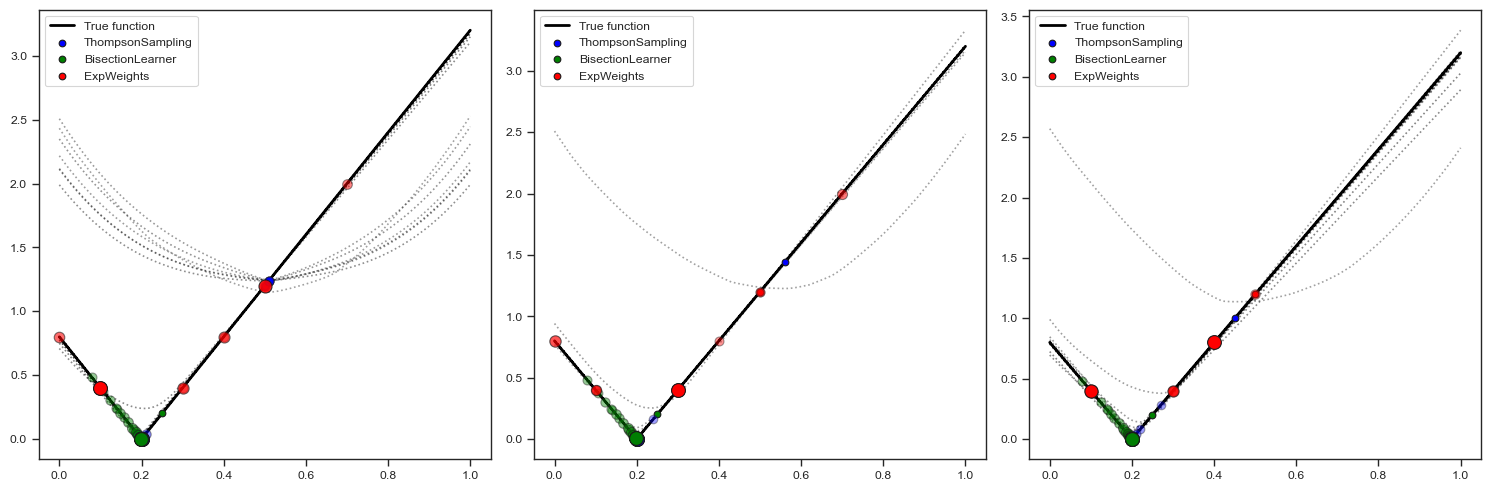

In [6]:
absolute_runner.plot_regret()
plot(absolute_value, absolute_runner)

## Linear

In [8]:
from bandit import BanditProblem
from runner import Runner
from functools import partial

from utils import linear

m = -0.1
a = 2
linear = partial(linear, m=m, a=a)

bandit = BanditProblem(w_true=None, ts=None, sigma=sigma, f_star=linear)

linear_runner = Runner(None, learner_configs, horizon, num_trials, problem=bandit)
linear_runner.run()

Optimal action and value:  Optimal action and value: Optimal action and value:  (np.float64(0.0), np.float64(0.2))
 (np.float64(0.0), np.float64(0.2))
(np.float64(0.0), np.float64(0.2))
Trial 2/3, Time step 0/100, Learner ThompsonSampling, Regret: 1.02
Trial 2/3, Time step 0/100, Learner BisectionLearner, Regret: 0.49999999999999994
Trial 2/3, Time step 0/100, Learner ExpWeights, Regret: 0.6000000000000001
Trial 3/3, Time step 0/100, Learner ThompsonSampling, Regret: 1.18
Trial 3/3, Time step 0/100, Learner BisectionLearner, Regret: 0.49999999999999994
Trial 1/3, Time step 0/100, Learner ThompsonSampling, Regret: 1.0
Trial 1/3, Time step 0/100, Learner BisectionLearner, Regret: 0.49999999999999994
Trial 3/3, Time step 0/100, Learner ExpWeights, Regret: 0.4000000000000001
Trial 1/3, Time step 0/100, Learner ExpWeights, Regret: 0.8
Trial 2/3, Time step 10/100, Learner ThompsonSampling, Regret: 4.680000000000001
Trial 2/3, Time step 10/100, Learner BisectionLearner, Regret: 7.5703125
Tria

{'ThompsonSampling': [array([ 1.02,  2.06,  2.82,  3.34,  3.68,  3.92,  4.12,  4.28,  4.44,
          4.56,  4.68,  4.8 ,  4.92,  5.04,  5.14,  5.24,  5.34,  5.46,
          5.56,  5.64,  5.72,  5.82,  5.88,  5.94,  6.02,  6.1 ,  6.22,
          6.32,  6.44,  6.56,  6.66,  6.72,  6.78,  6.86,  6.98,  7.04,
          7.06,  7.16,  7.28,  7.34,  7.48,  7.58,  7.6 ,  7.66,  7.72,
          7.78,  7.88,  7.98,  8.1 ,  8.18,  8.28,  8.36,  8.46,  8.56,
          8.62,  8.72,  8.84,  8.9 ,  8.98,  9.08,  9.12,  9.18,  9.26,
          9.36,  9.42,  9.52,  9.56,  9.64,  9.76,  9.86,  9.94, 10.  ,
         10.04, 10.1 , 10.16, 10.28, 10.34, 10.4 , 10.48, 10.5 , 10.6 ,
         10.72, 10.76, 10.88, 10.96, 11.04, 11.12, 11.2 , 11.3 , 11.4 ,
         11.46, 11.5 , 11.56, 11.62, 11.66, 11.7 , 11.78, 11.88, 11.94,
         11.98]),
  array([ 1.18,  2.06,  2.62,  3.02,  3.3 ,  3.52,  3.68,  3.82,  3.92,
          4.02,  4.12,  4.22,  4.3 ,  4.38,  4.44,  4.52,  4.6 ,  4.7 ,
          4.78,  4.86,  4.

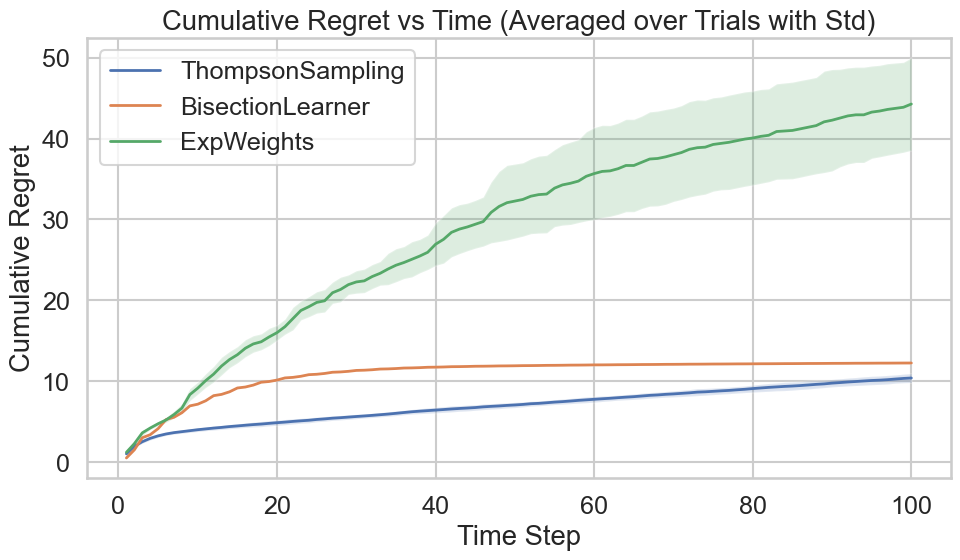

In [6]:
linear_runner.plot_regret()
plot(linear, linear_runner)

In [81]:
def plot(f_star, runner):
    sns.set_theme(style="ticks", context="paper", font_scale=1)
    n_learners = len(runner.learners)
    fig, axs = plt.subplots(1, n_learners, figsize=(5 * n_learners, 5), squeeze=False)
    axs = axs[0]  # get the row of axes

    algo_names = list(runner.learners[0].keys())

    colors = [
        "blue",
        "green",
        "red",
        "purple",
        "orange",
        "brown",
        "pink",
        "gray",
        "olive",
        "cyan",
    ]

    for j in range(n_learners):
        ax = axs[j]
        y_true = [f_star(x_i) for x_i in x]
        ax.plot(x, y_true, label="True function", color="black", linewidth=2)

        ts = runner.learners[j]["ThompsonSampling"]
        for i in range(horizon):
            if i % 3 != 0:
                continue
            # plot Thompson Sampling's function estimates
            ws = ts.ws[i]
            xs = np.linspace(0, 1, 500)
            ys = f(xs, ws, n)
            ax.plot(
                xs,
                ys,
                alpha=np.exp(0.01 * (i - horizon)),
                linestyle=":",
                color="black",
            )

            for k, alg_name in enumerate(algo_names):
                learner = runner.learners[j][alg_name]
                action = learner.history_x[i]
                if i == 0:
                    ax.scatter(
                        action,
                        f_star(action),
                        color=colors[k],
                        label=alg_name,
                        edgecolor="k",
                        # alpha=(1 / horizon) * i,
                        zorder=3,
                    )
                else:
                    ax.scatter(
                        action,
                        f_star(action),
                        color=colors[k],
                        edgecolor="k",
                        alpha=np.exp(0.01 * (i - horizon)),
                        zorder=3,
                        s=100 * np.exp(0.01 * (i - horizon)),
                    )
        ax.legend()

    plt.tight_layout()
    plt.show()